## Schlüsselwörter Notebook Aufgabe 2
Eine Zusammenfassung der wichtigsten Erkenntnisse und Ergebnisse befindet sich in der mit abgegebenen Abschlusspräsentation. Dieses Notebook behandelt die gestellte Aufgabe 2 der Shared Tasks und wurde von Jan Moormann und Sophia Bühl bearbeitet. 

#### Pakete installieren
Zur Installation und Verwaltung von Paketen in Python wird pip verwendet. Die für das Notebook benötigten Pakete werden nachfolgend installiert.

In [105]:
! pip install -r requirements.txt

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python3.9 -m pip install --upgrade pip


#### Pakete importieren
Die installierten Pakete müssen anschließend importiert werden, um sie verwenden zu können.

In [107]:
import os
from keybert import KeyBERT
import pandas as pd

import nltk
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

from HanTa import HanoverTagger as ht

import csv
import ast

import numpy as np

import requests
import re

import shutil
import random

from threading import Thread

import yake

import time
import random
import math

import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity 

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sophiabuehl/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sophiabuehl/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Statische Variablen
In diesem Abschnitt werden die statischen Variablen definiert, um in den folgenden Funktionen auf sie zugreifen zu können. Dies dient der Übersicht und dem Verständnis des Codes.

Um nicht nur das Subset, sondern alle exzellenten Artikel nutzen zu können, muss der Pfad entsprechend auskommentiert werden. Die Artikel sind in der statischen Variablen **TEXT_FOLDER** gespeichert. In **TARGET_FOLDER** befindet sich ein Subset zur Demonstration. Der Pfad kann hier angepasst werden.



*Wenn der Code mit dem gesmaten Datensatz durchgeführt werden soll muss unbdeingt **TARGET_FOLDER** mit **TEXT_FOLDER** überall ersetzt werden!*

In [108]:
# whole set of excellet articles
#TEXT_FOLDER = './data/exzellent'

# subset of the excellent articles (faster) / comment thgis out if you want to try it with the whole dataset
TEXT_FOLDER = './data/subset/exzellent'
TARGET_FOLDER = './data/subset/keywords_subset'

# folder for the cleaned articles
CLEANED_FOLDER = './data/cleaned_exzellent/'

# results for the count method
COUNT_CSV = "count.csv"

# results for the keybert
KEYBERT_CSV = "keybert.csv"

# results for the yake
YAKE_CSV = 'yake.csv'

In [109]:
def create_subset(text_folder, target_folder, num_articles=25, random_seed=42):
    # Liste aller Dateien im Textordner
    all_files = os.listdir(text_folder)
    # Zufällige Auswahl von 'num_articles' Dateien mit festem Seed
    random.seed(random_seed)
    selected_files = random.sample(all_files, num_articles)

    # Erstelle den Zielordner, wenn er nicht existiert
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)

    # Kopiere die ausgewählten Dateien in den Zielordner
    for file_name in selected_files:
        source_path = os.path.join(text_folder, file_name)
        target_path = os.path.join(target_folder, file_name)
        shutil.copy(source_path, target_path)

In [110]:
RANDOM_SEED = 42

create_subset(TEXT_FOLDER, TARGET_FOLDER, num_articles=25, random_seed=RANDOM_SEED)

### Vorbereitung der Daten
#### Speichern der Artikel mit Titel
In dieser Funktion wird der Dateiname in den Titel des Wikipedia-Artikels geändert, von dem er abhängt. Dadurch kann bei den Ergebnissen der Artikel nachvollziehbar zugeordnet werden und übersichtlich dargestellt werden. Es wird nur der Pfad zu den exzelleten Artikeln benötigt. Diese wurden in dem vorherigen Notebook extrahiert.

In [111]:
def change_file_name(TARGET_FOLDER):
    """
    Renames the article-files based on the article title extracted from the file

    Args:
        TARGET_FOLDER (str): The path to the text folder

    """

    # for loop to generate folder if it doesn't exist
    for file_name in os.listdir(TARGET_FOLDER):
        file_path = os.path.join(TARGET_FOLDER, file_name)

        # check if txt file, otherwise decode error
        # Idea from https://stackoverflow.com/questions/38518023/unicodedecodeerror-utf8-codec-cant-decode-byte-0x80-in-position-3131-invali
        if file_name.endswith(".txt"):
            file_path = os.path.join(TARGET_FOLDER, file_name)

            # open file and read lines
            with open(file_path, "r", encoding="utf-8") as file:
                row = file.readlines()
                    
                # if the line is not empty
                if row:
                        
                    # extrect article title from first line
                    titel = row[0].strip()

                    # clean the title from special chars
                    chars = r'[<>:"/\\|*]'
                    cleaned_titel = re.sub(chars, '', titel)

                    # get new file name
                    new_file_name = cleaned_titel + ".txt"
                    new_file_path = os.path.join(TARGET_FOLDER, new_file_name)

                    # rename the file
                    os.rename(file_path, new_file_path)

In [112]:
# call function to change file name 
change_file_name(TARGET_FOLDER)

#### Text der exzellenten Artikel säubern
Zur Vorverarbeitung der exzellenten Artikel wird der Inhalt der jeweiligen Textdateien eingegeben. Danach werden die Token gebildet, um den Text in kleinere Einheiten zu unterteilen. Mit dem HannoverTagger werden alle nicht benötigten Wortarten aus dem Text gefiltert. Nur Substantive, Eigennamen und Adjektive bleiben übrig. Diese Wortarten sind für die Schlüsselwörter prädestiniert, da somit ein Substantiv und ein beschreibendes Adjektiv das Schlüsselwort bilden und damit Aufschluss über den Text des Artikels geben können. Es hat sich im Versuch der Vorteil ergeben, dass HTML-spezifische zeichen dadurch herausgefiltert werden und auch Tabellen nicht mehr berücksichtigt werden. Dadurch wurde eine einfache und wirksame Methode gefunden, um die Artikel zu filtern und nur die benötigten Wörter zu erhalten, um sinnvolle Schlüsselwörter zu bilden. Anschließend wird der Text gefiltert und in die Textdatei umgeschrieben und in einem separaten Ordner gespeichert.

Das Paket des HannoverTagger wird von https://github.com/wartaal/HanTa und ursprünglich von https://serwiss.bib.hs-hannover.de/frontdoor/index/index/docId/1527 verwendet. In diesem Zusammenhang wird es genutzt, um das POS-Tagging durchzuführen. Das bedeutet, dass der Text in Substantive, Verben, Adjektive und so weiter kategorisiert wird, um abschließed danach zu filtern.

In [113]:
# define tagger
tagger = ht.HanoverTagger('morphmodel_ger.pgz')

In [114]:
def clean_text(txt_file):
    """
    Cleans the text in the file by tokenizing, POS-tagging, and lemmatizing nouns and adjectives

    Args:
        txt_file (str): The name of the txt file to be cleaned

    """

    # path to text file
    input_path = os.path.join(TARGET_FOLDER, txt_file)

    # read the txt file
    with open(input_path, 'r') as file:
        text = file.read()

    # tokenize the text of each file and define the language
    words = nltk.word_tokenize(text, language='german')

    # POS-Tagging with the Hanover-Tagger
    tagged_words = tagger.tag_sent(words)
    pos_tags = [(word, tag) for word, _, tag in tagged_words]

    # Lemmatize nouns and adjectives
    lemmatizer = WordNetLemmatizer()
    cleaned_words = []
    for word, pos in pos_tags:
        if pos.startswith('NN'):  # Nomen
            lemma = lemmatizer.lemmatize(word, wordnet.NOUN)
            cleaned_words.append(lemma)
        elif pos.startswith('NE'):  # Namen
            cleaned_words.append(word)
        elif pos.startswith('ADJ'):  # Adjektive
            lemma = lemmatizer.lemmatize(word, wordnet.ADJ)
            cleaned_words.append(lemma)

    # Merge the cleaned words into a cleaned text
    cleaned_text = ' '.join(cleaned_words)

    # save the cleaned text
    output_path = os.path.join(CLEANED_FOLDER, txt_file)
    with open(output_path, 'w') as file:
        file.write(cleaned_text)

#### Daten säubern und speichern
In der folgenden Funktion wird die eigentliche Bereinigung durchgeführt. Dazu legen wir einen neuen Ordner für die bereinigten Artikel an, falls er nicht schon vorhanden ist. Threads werden verwendet, um den Prozess zu beschleunigen.

In [115]:
def clean_data(CLEANED_FOLDER, TARGET_FOLDER):
    """
    Cleans the text data in the folder and saves the cleaned files in another folder

    Args:
        CLEANED_FOLDER (str): The path to the cleaned folder
        TARGET_FOLDER (str): The path to the text folder

    """

    # path to file with cleaned erticles
    if not os.path.exists(CLEANED_FOLDER):
        os.makedirs(CLEANED_FOLDER)

    # list with all the files
    txt_files = [file for file in os.listdir(TARGET_FOLDER) if file.endswith('.txt')]

    # iterate over files
    for txt_file in txt_files:
       clean_text(txt_file)

In [116]:
clean_data(CLEANED_FOLDER, TARGET_FOLDER)

### Schlüsselwörter identifizieren

#### Schlüsselwörter mit KeyBert
In dieser Funktion werden die Schlüsselwörter generiert. Hierfür wird das KeyBert-Modell verwendet. Für jeden Artikel werden fünf Schlüsselwörter bzw. Phrasen mit jeweils zwei Wörtern identifiziert. Hierfür werden 15 Kandidaten gebildet und möglichst viele verschiedene davon ausgewählt, um eine hohe Diversität der Schlüsselwörter zu erreichen.

Das KeyBert-Modell wurde von https://github.com/MaartenGr/KeyBERT übernommen und funktioniert wie folgt. KeyBert generiert Schlüsselwörter oder Keyphrasen aus einem Text auf Basis von Ähnlichkeiten. Es verwendet die Bert-Embeddings, um die ähnlichsten Wörter des Dokuments zu ermitteln. Die Wort-Embeddings extrahieren N-Gramme und definieren die Schlüsselwörter, die den gesamten Text am besten beschreiben. KeyBert ist ein einfaches und leicht zu benutzendes Modell in der NLP für eine Schlüsselwort-Extraktion. Aus den gebildeten möglichen Schlüsselwörtern werden möglichst verschiedene ausgewählt, um eine große Diversität in den Schlüsselwörtern zu erhalten und wenig Dopplungen in den Schlüselwörtern zu erhalten.

In [117]:
def keybert_keywords(TARGET_FOLDER, CLEANED_FOLDER):
    """
    Extracts keywords using the KeyBERT model for the articles and returns DataFrame with the titles and extracted keywords

    Args:
        TARGET_FOLDER (str): path to the text folder
        CLEANED_FOLDER (str): path to the cleaned folder

    Returns:
        DataFrame: DataFrame with the titles and extracted keywords

    """

    # empty list for dataset
    data = []

    # get the files in folder
    for filename in os.listdir(TARGET_FOLDER):

        # check if it is a txt file
        if filename.endswith(".txt"):

            # read text files
            txt_path = os.path.join(CLEANED_FOLDER, filename)
            with open(txt_path, 'r', encoding='utf-8') as f:
                content = f.read()

            # extract keywords for title with KeyBert model
            kw_model = KeyBERT()
            keywords = kw_model.extract_keywords(content, keyphrase_ngram_range=(1, 2)
                                                 , use_maxsum=True,  top_n=5
                                                 ,  nr_candidates=15)

            # extract title out of filename
            title = os.path.splitext(filename)[0]

            # add dataset to list
            data.append({'Titel': title, 'Schlüsselwörter': keywords})

    # create dataframe with keywords and title
    df_keybert = pd.DataFrame(data)

    return df_keybert

In [118]:
df_keybert = keybert_keywords(TARGET_FOLDER, CLEANED_FOLDER)

In [119]:
# print the head of the df to proof the results
#print(df_keybert.head)

#### Themen anhand der Wort-Häufigkeit
Um einen zusätzlichen Überblick zu erhalten, wird eine regelbasierte Methode angewendet. Dabei werden die Wörter im Wikipedia-Artikel gezählt und die Wörter mit der größten Anzahl als Themen des Artikels identifiziert. Es wird also davon ausgegangen, dass die Wörter, die einen Artikel am besten beschreiben und repräsentieren, auch am häufigsten im jeweiligen Artikel vorkommen.

Dieser Ansatz bringt aber auch Nachteile mit sich. Durch das reine Zählen der Wörter werden diese ohne den zugehörigen Kontext betrachtet, wodurch in manchen Fällen auch irrelevante Wörter als Schlüsselwörter identifiziert werden können. Zudem ist eine gute Bereiningung der Artikel notwendig, um keine Stoppwörter zu erkennen, oder Zeichen als Schlüsselwörter zu haben. 

Dennoch ist der Ansatz des Wörterzählens vergleichsweise einfach und intuitiv. Durch Methoden wie die TF-IDF Berechnung wird nicht nur die Häufigkeit, sondern auch die Seltenheit in den anderen Dokumenten überprüft und ist daher ein guter Ansatz, um die Schlüsselwörter in den Artikeln zu identifizieren. Die Wörter werden nicht einfach nur gezählt (Vgl. https://www.visitor-analytics.io/de/glossar/t/term-frequency-inverse-document-frequency-tf-idf/# 14.06.23).

Für die Funktion count_words() wurde ChatGPT zur Inspiration genutzt und Teile daraus entnommen! Die Kommentare wurden selbstständig hinzugefügt, um den Code zu verstehen.

In [120]:
def count_words(TARGET_FOLDER, CLEANED_FOLDER, COUNT_CSV):
    """
    Counts the words in the articles and saves all articles with the frequent words to a CSV

    Args:
        TARGET_FOLDER (str): path to the text folder
        CLEANED_FOLDER (str): path to the cleaned folder
        COUNT_CSV (str): path to the output CSV file
    """

    # create dictionary to store the counts of the words
    article_word_counts = {}

    # get list of stopwords
    stop_words = set(stopwords.words('german'))

    # get files in folder
    file_list = [filename for filename in os.listdir(TARGET_FOLDER) if filename.endswith(".txt")]

    for filename in file_list:

        # read the txt files fro folder
        txt_path = os.path.join(CLEANED_FOLDER, filename)
        with open(txt_path, 'r', encoding='utf-8') as f:
            content = f.read()

        # split the defined content into words
        words = content.split()

        # remove stopwords and proof if the words are alphabetic
        words = [word.lower() for word in words if word.lower() not in stop_words and word.isalpha()]

        # update the count of the words
        word_counts = Counter(words)
        article_word_counts[filename] = word_counts

    # create the output folder
    output_dir = os.path.dirname(os.path.abspath(COUNT_CSV))
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # create the output CSV
    with open(COUNT_CSV, 'w', newline='', encoding='utf-8') as csvfile:
        fieldnames = ['Titel', 'Schlüsselwörter']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        # write results into the csv
        for article, word_counts in article_word_counts.items():

            # get the most common words
            most_common = word_counts.most_common(5)

            # delete keywords with only one sign and the 'isbn'
            words_list = [word for word, count in most_common if len(word) > 1 and word.lower() != 'isbn']

            # write the results into te list
            writer.writerow({'Titel': article, 'Schlüsselwörter': ', '.join(words_list)})

In [121]:
# call the function
most_common = count_words(TARGET_FOLDER, CLEANED_FOLDER, COUNT_CSV)

In [122]:
# load CSV file
data = pd.read_csv(COUNT_CSV)

# initialize tf-idf vectorizer
vectorizer = TfidfVectorizer()

# compute tf-idf matrix for all articles
corpus = []
for filename in data['Titel']:
    txt_path = os.path.join(CLEANED_FOLDER, filename)
    with open(txt_path, 'r', encoding='utf-8') as f:
        content = f.read()
    corpus.append(content)
tfidf_matrix = vectorizer.fit_transform(corpus)

In [123]:
# bring the csv file into the correct format for the following code
with open(COUNT_CSV, 'r', newline='', encoding='utf-8') as csvfile:

    # define reader
    reader = csv.reader(csvfile)

    # skip head line
    next(reader)

    with open(COUNT_CSV, 'w', newline='', encoding='utf-8') as outfile:

        # define writer
        writer = csv.writer(outfile)

        # write the header of the csv 
        writer.writerow(['Titel', 'Schlüsselwörter'])

        for row in reader:

            # delete the .txt ending of the article names
            title = row[0].replace('.txt', '')
            keywords = row[1]
            writer.writerow([title, keywords])

#### Schlüsselwörter mit YAKE
Um einen Vergleich zwischen den Schlüsselwörtern zu haben und sie in der Evaluation besser bewerten zu können, wird ein zusätzliches Modell für die Schlüsselwortextraktion herangezogen. Die Struktur der Funktion ist dem KeyBert-Modell sehr ähnlich. Fünf Schlüsselwörter werden auf der Grundlage von Textmerkmalen mit jeweils zwei Wörtern generiert, um die treffendsten Schlüsselwörter zu erhalten.

Das YAKE-Modell wurde von https://github.com/LIAAD/yake übernommen. Es teilt den Artikel in Wörter und einzelne Phrasen auf und weist diesen Gewichten zu. Die Gewichtung entsteht durch die Anzahl, wie oft Wörter im Text vorkommen und wie sie im Text verteilt sind. Um genauere Schlüsselwörter zu erhalten, die nicht nur auf der Frequenz und Verteilung beruhen, versucht YAKE zudem den Kontext zu erfassen, indem zusätzlich die Wörter im Umkreis betrachtet werden.

In [124]:
def yake_keywords(TARGET_FOLDER, CLEANED_FOLDER):
    """
    Extracts keywords using YAKE for the articles and returns DataFrame with the titles and extracted keywords

    Args:
        TARGET_FOLDER (str): The path to the text folder
        CLEANED_FOLDER (str): The path to the cleaned folder

    Returns:
        DataFrame: DataFrame with the titles and extracted keywords

    """

    # empty list for dataset
    data = []

    # get the files in the folder
    for filename in os.listdir(TARGET_FOLDER):

        # check if it is a txt file
        if filename.endswith(".txt"):
        
            # read text files
            txt_path = os.path.join(CLEANED_FOLDER, filename)
            with open(txt_path, 'r', encoding='utf-8') as f:
                content = f.read()

            # extract keywords for title with Yake model
            kw_extractor = yake.KeywordExtractor()
            keywords = kw_extractor.extract_keywords(content)

            # extract title out of filename
            title = os.path.splitext(filename)[0]

            # extract only the first two words from the keywords
            extracted_keywords = [" ".join(kw[0].split()[:2]) for kw in keywords[:5]]

            # add dataset to list
            data.append({'Titel': title, 'Schlüsselwörter': extracted_keywords})

    # create dataframe with keywords and title
    df_yake = pd.DataFrame(data)

    return df_yake


In [125]:
df_yake = yake_keywords(TARGET_FOLDER, CLEANED_FOLDER)

#### Dateien in richtiges Format bringen
Speichern der Dataframes aus den beiden Modellen in einer csv-Datei, um damit einfacher weiter arbeiten zu können.

In [126]:
# save the dataframe back into a csv file
df_keybert.to_csv('./keybert.csv') 
df_yake.to_csv('./yake_output.csv')

**Säubern der KeyBert CSV-Datei** <br>
Das KeyBert-Modell enthält in der CSV noch den Score für jedes Schlüsselwort, der angibt, wie ähnlich es dem Text ist. Es ist gut, diese Zahl als einen ersten Indikator für die Leistung des Keybert-Modells zu nutzen. Aber die Zahl wird für den weiteren Code nicht benötigt und soll aus der csv-Datei extrahiert werden. Deshalb werden die nächsten beiden Funktionen definiert.

In [127]:
def clean_keywords(keyword_str):
    """
    Cleans the keyword string and returns a list of cleaned keywords

    Args:
        keyword_str (str): The keyword string

    Returns:
        list: List of cleaned keywords

    """

    # keyword_str into a python list 
    keyword_list = ast.literal_eval(keyword_str)

    # iterate over list and get first element
    cleaned_keywords = [keyword[0] for keyword in keyword_list]
    
    return list(cleaned_keywords)

In [128]:
def process_keywords_csv(input_file, output_file): 
    """
    Cleans the keywords and writes the cleaned data to a CSV

    Args:
        input_file (str): The path to input CSV
        output_file (str): The path to output CSV

    """

    # opens csv-file   
    with open(input_file, 'r', encoding='utf-8') as file:

        # read csv-file as dictionary
        csv_reader = csv.DictReader(file)

        # save the rows separately
        rows = list(csv_reader)

        # clean the rows with the function above
        keywords = [(row['Titel'], clean_keywords(row['Schlüsselwörter'])) for row in rows]

    # open output file
    with open(output_file, 'w', newline='', encoding='utf-8') as file:

        # create csv writer
        writer = csv.writer(file)

        # define the column names and write it in output file
        writer.writerow(['Titel', 'Schlüsselwörter'])

        # write keywords in output file
        for keyword in keywords:
            writer.writerow(keyword)

In [129]:
process_keywords_csv('keybert.csv', 'key_output.csv')

### Beispielhafte Visualisierung der Ergebnisse
In der folgenden Zelle wird eine Wortwolke zu einem beispielhaften Artikel erstellt, um die identifizierten Schlüsselwörter zu visualisieren. Daraus wird ersichtlich, dass sich der Artikel mit dem Externsteine befasst. Es ist zudem erkennbar, dass es sich dabei um ein Felsengrab handelt und der Felsen im Teutoburgerwald liegt, welcher sich im Nordwesten Deutschlands befindet. Zudem ist ein Stadtteil nach dem Felsen benannt, nämlich Holzhausen-Externsteine. Die Schlüsselwörter beschreiben den Artikel und bieten sinnvollen Aufschluss über dessen Inhalt.

Die beschriebene Wortwolke nutzt die Schlüsselwörter des KeyBert-Modells. Um zu sehen, wie gut das Modell abschniedet, wurden zusätzlich die Schlüsselwörter mit dem YAKE-Modell erstellt. Es fällt direkt auf, dass die zweite Wortwolke nicht mehr abbildet, worum es sich in dem Text handelt und es für einen außenstehenden Betrachter nicht zu erkennen ist, dass es sich um einen Artikel über die Externsteine handelt. Dies ist ein erneutes Anzeichen, dass KeyBert besser abschneidet, als YAKE.

#### Visualisierung KeyBert

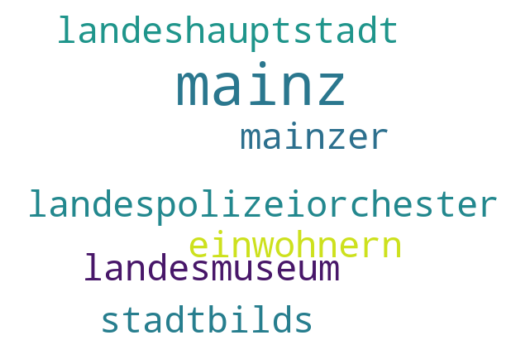

In [130]:
# idea from: https://www.analyticsvidhya.com/blog/2021/08/creating-customized-word-cloud-in-python/ (12.06.23)
# read csv file
df = pd.read_csv('key_output.csv')

# title from article
title_visualize_keybert = 'Mainz'

# filter keywords for title
keywords_visualize_keybert = df.loc[df['Titel'] == title_visualize_keybert, 'Schlüsselwörter'].values[0]

# konvert keywords to string
keywords_str_keybert = ' '.join(eval(keywords_visualize_keybert))

# create wordcloud
wordcloud_keybert = WordCloud(width=600, height=400, background_color='white', max_font_size=70).generate(keywords_str_keybert)

# plot the wordcloud
plt.imshow(wordcloud_keybert, interpolation='bilinear')
plt.axis('off')
plt.show()

#### Visualisierung Wörter zählen

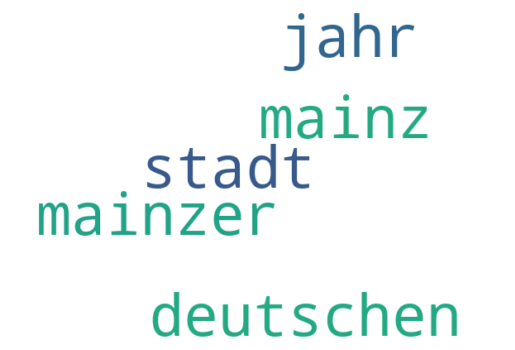

In [131]:
# Read the count.csv file
df = pd.read_csv('count.csv')

# Specify the title of the article
title_visualize_keybert = 'Mainz'

# Filter keywords for the specified title
keywords_visualize_keybert = df.loc[df['Titel'] == title_visualize_keybert, 'Schlüsselwörter'].values[0]

# Convert keywords to string
keywords_str_keybert = keywords_visualize_keybert.replace(', ', ' ')

# Create wordcloud
wordcloud_keybert = WordCloud(width=600, height=400, background_color='white', max_font_size=70).generate(keywords_str_keybert)

# Plot the wordcloud
plt.imshow(wordcloud_keybert, interpolation='bilinear')
plt.axis('off')
plt.show()

#### Visualisierung YAKE

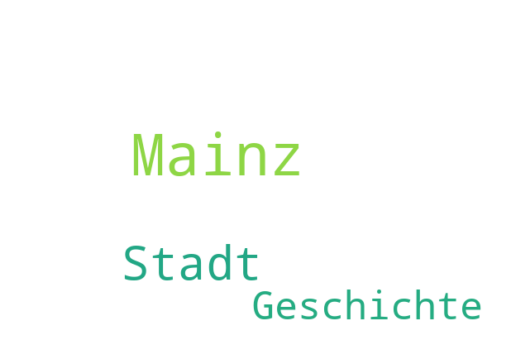

In [132]:
# read csv file
df = pd.read_csv('yake_output.csv')

# title from article
title_visualize = 'Mainz'

# filter keywords for title
keywords_visualize_yake = df.loc[df['Titel'] == title_visualize, 'Schlüsselwörter'].values[0]

# konvert keywords to string
keywords_str_yake = ' '.join(eval(keywords_visualize_yake))

# create wordcloud
wordcloud_yake = WordCloud(width=600, height=400, background_color='white', max_font_size=70).generate(keywords_str_yake)

# plot the wordcloud
plt.imshow(wordcloud_yake, interpolation='bilinear')
plt.axis('off')
plt.show()

### Evaluation der Schlüsselwörter - Kosinus-Score
Das KeyBert Modell nutzt die Kosinus-Ähnlichkeit, um die Ähnlichkeit der identifizierten Schlüsselwörter zum Textdokument zu ermitteln. Die Wörter Kosinus-Ähnlichkeit und Ähnlichkeits-Score werden synonym verwendet. Für die Kosinus-Ähnlichkeit wird der Kosinus des Winkels der beiden Vektoren bestimmt. Dadurch kann ermittelt werden, ob die beiden Vektoren in eine Richtung zeigen. Der Score kann dabei zwischen -1 und +1 liegen. Im Minusbereich sind die Vektoren entgegengesetzt ausgerichtet, während sie im Plusbereich in eine ähnliche Richtung zeigen. Je näher sich die Vektoren sind und desto kleiner der Winkel ist, desto höher ist der Ähnlichkeits-Score des KeyBert Modells. (Vgl. https://www.learndatasci.com/glossary/cosine-similarity/ letzter Aufruf: 24.05.2023) 

Der Kosinus Score lässt sich zudem auch für die beiden anderen Vorgehensweisen berechnen und damit eine Vergleichbarkeit der Modelle herstellen.

Um nicht für alle über 2700 exzellenten Wikipedia Artikeln einzeln diesen Score zu interpretieren, wird in der folgenden Funktion zunächst der Ähnlichkeits-Score jedes Artikels berechnet und anschließend das Mittel über alle Artikel ermittelt. Es ergibt sich ein erster Eindruck, wie gut die identifizierten Schlüsselwörter im Schnitt zu den Artikeln passen.

In [133]:
def calculate_average_similarity(df_keybert):
    """
    Calculates the average similarity score for the articles in the DataFrame

    Args:
        df_keybert (DataFrame): DataFrame containing the titles and extracted keywords with the similarity scores

    Returns:
        float: The average similarity score for all articles

    """

    # empty list for the scores
    article_scores = []
    
    for index, row in df_keybert.iterrows():

        # keywords in the column Schlüsselwörter
        keywords = row['Schlüsselwörter']
        
        # set variables for count
        total_score = 0
        count = 0
        
        # iterate over the keywords in articles
        for keyword in keywords:
            # score is on second place in the tuple
            similarity_score = keyword[1]
            # score is added to score of the article
            total_score += similarity_score
            count += 1
        
        # calculate the article score for each article file
        if count > 0:
            average_score = total_score / count
        else:
            # dont want to divide by 0 if there is no score
            average_score = 0
        
        # append the article score to the list
        article_scores.append(average_score)
    
    # calculate score over all articles
    if len(article_scores) > 0:
        articles_average_score = sum(article_scores) / len(article_scores)
    else:
        articles_average_score = 0
    
    return articles_average_score

In [134]:
def compute_average_cosine_similarity(tfidf_matrix):
    """
    Computes average cosine similarity between all the articles

    Args:
        tfidf_matrix (ndarray): TF-IDF matrix

    Returns:
        float: average cosine similarity
    """

    # compute the cosine similarity of all the articles
    cosine_similarities = cosine_similarity(tfidf_matrix, tfidf_matrix)
    cosine_similarities = cosine_similarities - np.eye(cosine_similarities.shape[0])

    # compute average cosine similarity
    average_similarity = np.mean(cosine_similarities)
    
    return average_similarity

#### KeyBert Kosinus-Score

In [135]:
average_similarity_keybert = calculate_average_similarity(df_keybert)
print("Average Similarity Score KeyBert:", average_similarity_keybert)

Average Similarity Score KeyBert: 0.563748


##### Winkel berechnen KeyBert
Um ein Gefühl dieses Wertes zu bekommen, wird nachfolgend zusätzlich der Winkel zum entsprechenden Kosinus-Score berechnet. Der in der folgenden Zelle ermittelte Winkel zum Konsinus-Score beträgt ungefähr 56 Grad. Das Ergebnis ist weit weg von den 180°, bei dem die Vektoren in die entgegengesetzte Richtung zeigen und kleiner als 90°. Null Grad wäre hier der beste Wert, da die Schlüselwörter im Mittel zum Artikel bestmöglich ähnlich sind und diesen perfekt abbilden. 

Die Artikel sind nicht nur einzelne Sätze oder Wörter und dementsprechend lang. Je länger ein Text ist, desto schwieriger wird es, dass einzelne Schlüsselwörter eine perfekte Ähnlichkeit zu einem ganzen Text besitzen. Aus diesen benannten Gründen ist eine gute durchschnittliche Ähnlichkeit für die identifizierten Schlüsselwörter zu den Artikeln zu erkennen und der Score von 0.56 ist in der ersten Evaluation ein guter Wert.

In [136]:
# for this code the documentation https://www.tutorialspoint.com/python/number_acos.htm was used

def calculate_angle(average_similarity):
    # calculate the radian measure
    angle = math.acos(average_similarity)

    # calculate the degree
    angle_degrees = math.degrees(angle)

    return angle_degrees

In [137]:
angle_degrees = calculate_angle(average_similarity_keybert)
print("Angle Cosine Score KeyBert:", angle_degrees)

Angle Cosine Score KeyBert: 55.68460470752645


##### Ergebnis KeyBert

Der ermittelte Ähnlichkeits-Score über alle deutschen, exzellenten Wikipedia Artikeln beträgt 0,56. Dies ist ein Indiz dafür, dass die Schlüsselwörter im Schnitt eine hohe Ähnlichkeit zum jeweiligen Artikel aufweisen. Ein Wert größer null bedeutet, dass die Vektoren in eine ähnliche Richtung zeigen und nicht voneinander abgewandt sind. Zudem ist der Winkel zwischen den Vektoren zur gegebenen Textlänge relativ klein. 

Die Ergebnisse über den Ähnlichkeits-Score geben erste Rückschlüsse, dass die gewählte Methode zur Schlüsselwörter-Identifizierung funktioniert und gute Ergebnisse erbringt. Um die erste Vermutung zu bestätigen und einen Vergleich zu einem anderen Modell zu haben, wird im nächsten Schritt das Yake Modell genutzt, um erneut Schlüsselwörter aus den Artikeln zu erstellen.

#### Wörter zählen Kosinus-Score
Um eine Metrik zu haben und die Ergebnisse der verschiedenen Modelle zu vergleichen wird die Kosinus-Ähnlichkeit genutzt. Diese wurde ausgewählt, da das KeyBert-Modell diesen Wert nutzt und automatisch berechnet. Zudem ist der Wert sehr einfach zu verstehen und nachvollziehbar, wodurch eine Interpretation möglich wird.

In [138]:
# compute average cosine similarity for all articles
average_similarity_count = compute_average_cosine_similarity(tfidf_matrix)

# print the average similarity
print("Average Cosine Similarity Count:", average_similarity_count)

Average Cosine Similarity Count: 0.017278023820540004


##### Winkel berechnen Wörter zählen

In [139]:
angle_degrees = calculate_angle(average_similarity_count)
print("Angle Cosine Score Count:", angle_degrees)

Angle Cosine Score Count: 89.00999289476832


##### Ergebnis Wörter zählen
Die Berechnung des Winkels hilft, den Kosinus-Score von ca. 0.0173 besser zu verstehen. Der Winkel des Scores für das Zählen der Wörter liegt bei ungefähr 89 Grad. Die Vektoren zeigen daher zwar ungefähr in die gleiche Richtung, da der Winkel noch kleiner 90° ist, aber der Winkel ist deutlich größer, als bei den Ergebnissen des KeyBert Modells. Die Schlüsselwörter sind demnach weniger ähnlich zum Text des Artikels.

#### YAKE Kosinus-Score

In [140]:
# create tf-idf-Vektor for keywords
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df_yake['Schlüsselwörter'].apply(lambda x: ' '.join(x)))

# calculate average cosinus score
average_similarity_yake = compute_average_cosine_similarity(tfidf_matrix)

# print the average cosinus score
print("Average Similarity Score YAKE:", average_similarity_yake)

Average Similarity Score YAKE: 0.002295741303892603


##### Winkel berechnen YAKE

In [141]:
angle_degrees = calculate_angle(average_similarity_yake)
print("Angle Cosine Score Count:", angle_degrees)

Angle Cosine Score Count: 89.86846359689072


##### Ergebnis YAKE
Die Kosinus-Ähnlichkeit beträgt mit dem YAKE-Modell ca. 0.0022. Dieser Wert ist Nahe null und zeigt daher an, dass der Winkel nahe der 90° sein muss. Die Vektoren stehen demnach orthogonal aufeinander und zeigen bereits in verschiedene Richtungen. Dadurch sind die identifizierten Schlüsselwörter dem Text nicht sehr ähnlich, wie die nachfolgende beispielhafte Visualisierung zeigt. Zu den anderen beiden Methoden liefert YAKE die schlechtesten Schlüsselwörter, um die jeweiligen Artikel zu beschreiben. Dies könnte daran liegen, dass die Daten für diese Methode falsch aufbereitet wurden, oder der Text für das Modell zu lang ist und eine Grenze erreicht wurde.

### Evaluation der Schlüsselwörter - Wikipedia API
Es wurden zwei Modelle mit unterschiedlichen Ansätzen ausprobiert, um die Schlüsselwörter aus den exzellenten deutschen Wikipedia-Artikeln zu erhalten. Da es keinen Datensatz mit den "richtigen" Schlüsselwörtern gibt, wird eine etwas andere als sinnvoll erachtete Methode zur Evaluierung in Betracht gezogen. Dazu werden die Schlüsselwörter über die Wikipedia-API in die Suchfunktion eingefügt. Anschließend wird geprüft, ob der erste gefundene Artikel mit dem Titel der eingegebenen Schlüsselwörter übereinstimmt.

Auf diese Weise lässt sich gut erkennen, ob die Schlüsselwörter dem Text ähnlich sind und alle relevanten Informationen aus dem Artikel enthalten. Wenn der richtige Artikel mit den identifizierten Schlüsselwörtern gefunden werden kann, ist dies ein guter Indikator für die richtigen Schlüsselwörter. 

Für jede der Schlüsselphrasen/Schlüsselwörter werden zwei Wörter verwendet, um die Grammatik nicht zu verlieren und den Text so gut wie möglich zu beschreiben und einen größeren Kontext abzudecken. Dies ist auch der Grund, warum die Grundformen der Wörter(Lemmatation) nicht verwendet werden, da sonst die Bedeutung hinter den beiden Wörtern verloren ginge und sie nicht mehr zusammenhängen würden. Es wurde versucht, eine Lemmatisierung (mit Spacy) durchzuführen. Aufgrund der geringen Auswahl an deutschen Lemmatisierern war es jedoch schwierig, einen geeigneten zu finden. Außerdem wurden viele Wörter falsch abgeschnitten, was dazu führte, dass die Grammatik und die Bedeutung hinter den Wörtern nicht mehr korrekt waren.

In [145]:
def get_search_result(search_query):
    """
    Retrieves the title of the first Wikipedia search result

    Args:
        search_query (str): The query string to search Wikipedia

    Returns:
        str or None: The title of the first search result, or None if there is no result

    """

    # language code to german
    language = 'de'

    # get only first result of the wikipedia search
    number_of_results = 1

    # empty dictionary for http header 
    headers = {}

    # url for API to search and create the full url
    api_url = 'https://api.wikimedia.org/core/v1/wikipedia/'
    endpoint = '/search/page'
    url = api_url + language + endpoint

    # set the parameters for the search
    parameters = {'q': search_query, 'limit': number_of_results}

    # send get request with url, header and parameters. Parse API rsponse as JSON
    response = requests.get(url, headers=headers, params=parameters)
    response = response.json()

    # if there is one result, return title
    if len(response['pages']) > 0:
        return response['pages'][0]['title']
    # if there is no result, return no title found
    else:
        pass
        return None

In [146]:
def validate_keywords(csv_file):
    """
    Validates keywords in the given CSV by searching for articles on Wikipedia

    Args:
        csv_file (str): The path to the CSV

    Returns:
        tuple: A tuple containing the count of articles

    """

    # count for the articles
    count_found = 0

    # open csv-file
    with open(csv_file, 'r', encoding='utf-8') as file:

        # create dictionary reader
        csv_reader = csv.DictReader(file)

        # iterate over the rows and count them in idx
        for idx, row in enumerate(csv_reader):

            # exrat title and keywords
            title = row['Titel']
            keywords = row['Schlüsselwörter'].split(', ')  # Split the string of keywords into a list
            
            # search article with keywords
            search_results = get_search_result(','.join(keywords))

            # if there is a search result 
            if search_results:
                found_title = search_results

                if found_title.lower() == title.lower():

                    # and the title is the same as the title in the csv-file
                    #print(f"The article '{found_title}' was found for the title '{title}'.")
                    count_found += 1

                else:
                    # and the title is not the same as the title in the csv-file
                    #print(f"The found article '{found_title}' is not matching the title '{title}'.")
                    pass
            else:
                # and no article was found
                #print(f"No article found for title '{title}'.")
                pass
                
            # break between 7 and 10 seconds, to have not too many requests for the API
            time.sleep(random.randint(7,10))
    
    return count_found, idx

In [147]:
# print the results for the evaluation
count_found_keybert, idx = validate_keywords('key_output.csv')
count_found_count, idx = validate_keywords('count.csv')
count_found_yake, idx = validate_keywords('yake_output.csv')
print("Keybert ### Gefunden:", count_found_keybert , 'von',idx + 1)
print("Count ### Gefunden:", count_found_count, 'von',idx + 1)
print("Yake ### Gefunden:", count_found_yake, 'von',idx + 1)


Keybert ### Gefunden: 21 von 25
Count ### Gefunden: 17 von 25
Yake ### Gefunden: 18 von 25


#### Evaluation der Schlüsselwörter - Links
Es wurde sich gegen eine Evaluation der Schlüsselwörter mithilfe der Verlinkungen in Wikipedia entschieden. Dies geschieht mit der Begründung, dass jeder bereits vorhandene Artikel, der das Thema auch nur ansatzweise streift, für gewöhnlich verlinkt wird. Dadurch werden auch Schlüsselwörter angegeben, die keinen direkten Kontext zum Artikel aufzeigen und keinen sinnvollen Beitrag für die Evaluation liefern. Ein Beispiel dafür ist die Verlinkung 'Sommersonnenwende' im Artikel 'Externsteine'. Dies wird zwar erwähnt, mit dem reinen Wort lässt sich aber nicht auf den Artikel schließen und ist daher kein gut gewähltes Schlüsselwort. Zudem sind in einem Artikel sehr viele Verlinkungen enthalten, wodurch eine Vielzahl überprüft werden müsste.

### Evaluation Ergebnisse
Wir können in den Ergebnissen sehen, dass alle drei ausgewählten Modelle eine gute Leistung bei der Erstellung von Schlüsselwörtern und dem Wiederfinden des richtigen Artikels bei der Wikipedia-Suche erzielen. Das zeigt, dass die Schlüsselwörter dem Text sehr ähnlich sind und dass die Schlüsselwörter die Artikel sehr gut beschreiben. 

Es wurden drei verschiedene Modelle zum Vergleich herangezogen, die unterschiedlich gut abschneiden. **KeyBert** schneidet erwartungsgemäß am besten ab. Das liegt daran, dass die Ähnlichkeit zum Artikel zur Identifikation der Schlüsselwörter verwendet wird. Darüber hinaus werden mehrere mögliche Schlüsselwörter gebildet und die unähnlichsten für die eigentliche Auswahl verwendet. Somit ist die Vielfalt der Schlüsselwörter sehr gut und decken alle relevanten Aspekte des Textes ab. Das Modell hat **21** der insgesamt 25 exzellenten deutschen Wikipedia-Artikel im Training aus dem Subset gefunden (insgesamt 2409 von 2739) gefunden. Dies entspricht einer Genauigkeit von **86,25%**. Der ermittelte Ähnlichkeits-Score des Subsets von 0.56 bestätigt die Ergebnisse des Modells. Dieser zeigt ebenfalls an, dass die Schlüsselwörter sehr ähnlich zum Text sind, da die Vektoren in die gleiche Richtung zeigen und der Winkel zwischen ihnen mit **56°** zur Textlänge vergleichsweise klein ist. Um eine bessere Genauigkeit zu erzielen, könnten mehr Schlüsselwörter generiert und in die Suche einbezogen werden. Die Vorverarbeitung des Textes scheint aufgrund der guten Keywords ausreichend zu sein.

Das Zählen der Wörter mit TF-IDF hat den Vorteil, dass nicht nur die Häufigkeit im aktuellen Artikel betrachtet wird, sondern auch die Häufigkeit des Wortes in anderen Artikeln. Dadurch kann bestimmten Schlüsselwörtern eine höhere Gewichtung zugeteilt werden. Die Ergebnisse sind zum KeyBert Modell mit einem Kosinus-Score von 0.0173 und einem Winkel von **89°** signifikant schlechter. Dennoch ist das Zählen der Wörter nach der ausgewählten Metrik etwas besser, als die Ergebnisse mit YAKE. Dennoch werden etwas weniger Artikel gefunden über die Wikipedia Suche, als bei den anderen beiden Modellen.

Das Modell **Yake** schneidet immer noch gut ab, aber etwas schlechter als die beiden vorherigen Modelle. Es verwendet Merkmale im Text, um die Schlüsselwörter zu erstellen. Die Tatsache, dass das Modell etwas schlechter abschneidet, liegt vermutlich an der Vorgehensweise des Modells und dass nicht die Ähnlichkeit betrachtet wird. Im Gegensatz zum KeyBert-Modell fand das Modell nur **18** von 25 Artikeln (insgesamt 2048 von 2793) auf der Grundlage der ermittelten Schlüsselwörter richtig. Das bedeutet, dass im Vergleich 3 (insgesamt 361) weniger exzellente Artikel gefunden wurden. Damit liegt die Genauigkeit des Yake-Modells bei nur **73,33%**. Zudem liegt der Wert der Kosinus-Ähnlichkeit fast bei Null (0.0023) und damit bei **90°**. Die Vektoren zeigen zwar nicht in eine entgegengesetzte Richtung, aber stehen orthogonal zueinander. Dennoch zeigt das Ergebnis, dass das Modell funktioniert, auch wenn keine guten Schlüsselwörter identifiziert werden. 

Die eindeutigste und nach den ausgewählten Metriken beste Schlüsselwortidentifikation wird demnach mit dem KeyBert-Modell erreicht und ist in diesem Fall zu bevorzugen. Es ist einfach zu verstehen und berechnet den Kosinus-Score bereits mit. Dadurch ist das Modell gleichzeitig einfach zu interpretieren und benötigt keinen zusätzlichen Aufwand.